In [1]:
from pathlib import Path
import sys
sys.path.append('/Users/tam/Documents/thesis/thesis_rl/src')

import pandas as pd
from datetime import datetime as dt
from datetime import timedelta

from gym_trading.utils.data_pipeline import DataPipeline


datapipeline = DataPipeline(None)

/Users/tam/miniconda3/envs/thesis/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
[2023-06-27 12:54:56,157, ema.py:65] EMA smoothing DISABLED


In [2]:
start_date = dt(2020,1,1) #of fitting, ie training starts on one day later
num_days = 2

paths = ['XBTUSD_' + (start_date+timedelta(i)).strftime("%Y-%m-%d") + '.csv.xz' 
         for i in range(num_days+1)]

normalized_dfs = pd.DataFrame()
raw_midpoints = pd.DataFrame()
for i in range(num_days):
    raw_midpoint, _, normalized_data = \
        datapipeline.load_environment_data(
            fitting_file=paths[i],#'XBTUSD_2020-01-02.csv.xz',
            testing_file=paths[i+1],#'XBTUSD_2020-01-03.csv.xz',
            include_imbalances=False,
            as_pandas=True
        )
    
    normalized_dfs = pd.concat([normalized_dfs, normalized_data])
    raw_midpoints = pd.concat([raw_midpoints, raw_midpoint])
normalized_dfs = pd.concat([normalized_dfs, raw_midpoints], axis=1)
normalized_dfs = normalized_dfs.rename(columns={normalized_dfs.columns[-1]: 'raw_midpoints'})

[2023-06-27 12:54:58,988, data_pipeline.py:49] Imported /XBTUSD_2020-01-01.csv.xz from a csv in 1 seconds
[2023-06-27 12:55:00,792, data_pipeline.py:49] Imported /XBTUSD_2020-01-02.csv.xz from a csv in 1 seconds
[2023-06-27 12:55:02,588, data_pipeline.py:49] Imported /XBTUSD_2020-01-02.csv.xz from a csv in 1 seconds
[2023-06-27 12:55:04,463, data_pipeline.py:49] Imported /XBTUSD_2020-01-03.csv.xz from a csv in 1 seconds


In [7]:
# Keep only 10 Levels of LOB
def filter_strings(strings):
    filtered_strings = []
    for string in strings:
        last_part = string.split('_')[-1]
        if ('ofi' in string) or (not last_part.isdigit() or int(last_part)>10):
            continue
        #print(string)
        filtered_strings.append(string)
    return filtered_strings

# calculate labels for predictions
def calculate_moving_average(df, k, threshold):
    # Calculate moving average including current value
    df['MovingAvg_Inclusive'] = df['raw_midpoints'].rolling(window=k, min_periods=k).mean()

    # Calculate moving average excluding current value but including future values
    df['MovingAvg_Exclusive'] = df['raw_midpoints'].shift(-k).rolling(window=k, min_periods=k).mean()

    # Calculate percentage change of lookahead moving average with respect to inclusive moving average
    df['PercentageChange'] = (df['MovingAvg_Exclusive'] - df['MovingAvg_Inclusive']) / df['MovingAvg_Inclusive']

    # Apply threshold conditions and add result column
    df['Result'] = df['PercentageChange'].apply(lambda x: 1 if x > threshold else (-1 if x < -threshold else 0))

    return df

#plot time series with changing backgroun colors depending on label
import matplotlib.pyplot as plt
import logging

logging.basicConfig(level='INFO')

mlogger = logging.getLogger('matplotlib')
mlogger.setLevel(logging.WARNING)


def plot_timeseries(df, y_col):
    # Set the figure size
    plt.figure(figsize=(15, 8))
    
    # Determine the background color for each label
    label_colors = {1: 'green', 0: 'white', -1: 'red'}
    
    # Plot the background color for each label
    for i in range(len(df)-1):
        label = df['Result'].iloc[i]
        color = label_colors[label]
        plt.axvspan(df.index[i], df.index[i+1], facecolor=color, alpha=0.2)
    
    # Plot the specified values on the y-axis
    plt.plot(df.index, df[y_col], 'b-', linewidth=1)
    
    # Set the x-axis label
    plt.xlabel('Time')
    
    # Set the y-axis label
    plt.ylabel(y_col)
    
    # Show the plot
    plt.show()

In [41]:
cols = normalized_dfs.columns
cols_red = filter_strings(cols)
cols_red += ['midpoint', 'spread', 'buys', 'sells', 'raw_midpoints']
normalized_dfs_red = normalized_dfs[cols_red]

normalized_dfs_red = calculate_moving_average(normalized_dfs_red, 10, 0.00005)

/var/folders/fl/_7zkqy_j7j73s6lx2yv46_nw0000gn/T/ipykernel_81067/1011492330.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['MovingAvg_Inclusive'] = df['raw_midpoints'].rolling(window=k, min_periods=k).mean()
/var/folders/fl/_7zkqy_j7j73s6lx2yv46_nw0000gn/T/ipykernel_81067/1011492330.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['MovingAvg_Exclusive'] = df['raw_midpoints'].shift(-k).rolling(window=k, min_periods=k).mean()
/var/folders/fl/_7zkqy_j7j73s6lx2yv46_nw0000gn/T/ipykernel_81067/101

<Axes: >

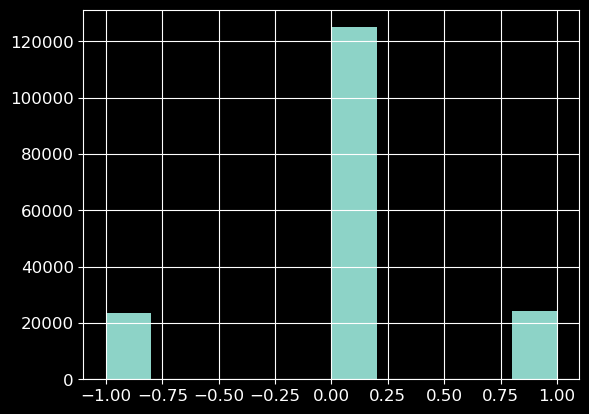

In [42]:
normalized_dfs_red.Result.hist()

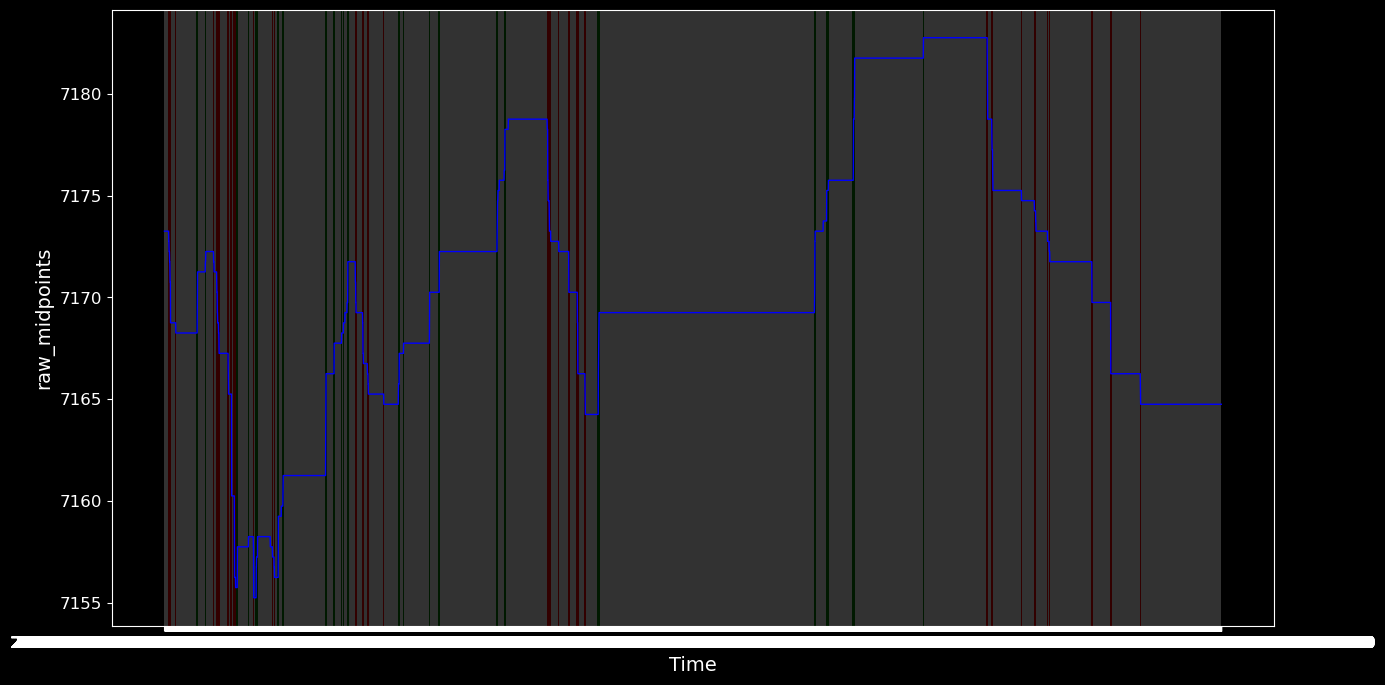

In [44]:
plot_timeseries(normalized_dfs_red.iloc[:10000].dropna(), 'raw_midpoints')